# Ensemble: tas + tos

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })
warnings.filterwarnings('ignore')

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'tas'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
conf_tos = [v for v in libs.vars.variables() if v['variable_id'] == 'tos'][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Temperature ({time_series_units})'
time_series_process = lambda x: x

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_time_series_tas = libs.local.get_ensemble_series(variable_id, experiment)
ensemble_time_series_tos = libs.local.get_ensemble_series('tos', experiment)

for key in ensemble_time_series_tos:
    ensemble_time_series_tos[key].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)) }


obs_arr = []
for obs in conf['obs']:
    obs_data = libs.local.get_obs(**obs)

    obs_arr.append({
        'color': obs_data.attrs['color'],
        'data': obs_data - 273.15,
        'label': obs_data.attrs['label']
    })
    
for obs in conf_tos['obs']:
    obs_data = libs.local.get_obs(**obs)

    obs_arr.append({
        'color': obs_data.attrs['color'],
        'data': obs_data - 273.15,
        'label': obs_data.attrs['label']
    })
    
obs_ts, obs_ts_smooth = libs.ensemble.time_series_weighted(
    obs_arr,
    weight,
    fillna=None,
    weighting_method=conf['weighting_method'],
    weighting_process=conf['weighting_process']
)

obs_ts_keys = {}
for i, item in enumerate(obs_ts):
    key = ' '.join([item['label'], item['data'].name])
    processed_data = item['data']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    processed_data.attrs['color'] = item['color']
    processed_data.attrs['label'] = key
    
    # Groupby + mean to resample from monthly time to year, then add to ensemble datasets
    obs_ts_keys[key] = processed_data


ds_obs = xarray.Dataset(data_vars=obs_ts_keys)
ds_obs['ERA5 t2m'].attrs['plot_kwargs'] = { 'linewidth': 3, 'zorder': 10 }
ds_obs['ERA5 sst'].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)), 'linewidth': 3, 'zorder': 10 }

## Time series

### Mean

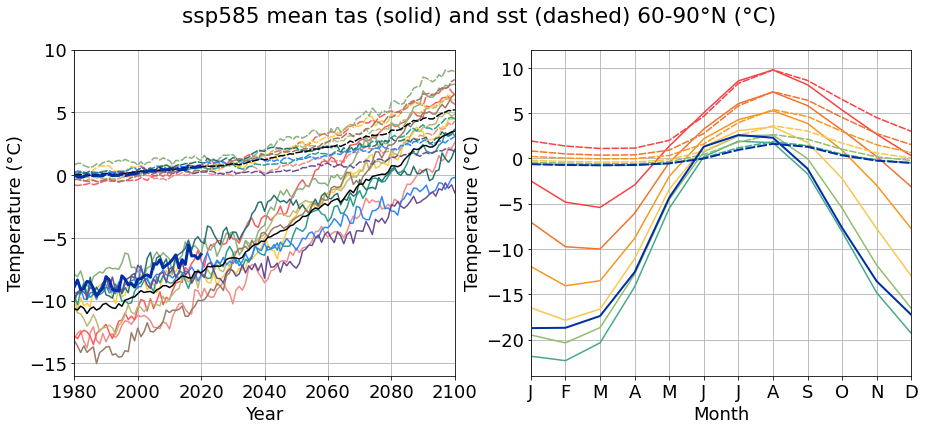

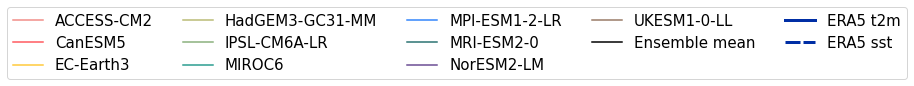

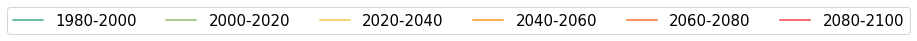

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(
    f'''{experiment} mean tas (solid) and sst (dashed) 60-90°N ({time_series_units})'''
)

vars_series = [
    { 'calc_mean': True, 'data': ensemble_time_series_tas },
    { 'calc_mean': True, 'data': ensemble_time_series_tos },
    { 'calc_mean': False, 'data': ds_obs },
]
plot_arr = []
variables_keys = []
for item in vars_series:
    item_processed = item['data'].groupby('time.year').mean('time') #.rolling(year=5, center=True).mean('year')

    if item['calc_mean']:
        item_processed = libs.ensemble.calc_variable_mean(item_processed)

    variables_keys.extend(list(item_processed))
    plot_arr.append(item_processed)

variables_keys = list(dict.fromkeys(variables_keys))
plot_arr[1]['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': (0, (5, 1)) }

libs.plot.time_series_from_vars(
    plot_arr,
    ax=axes[0],
    fig=fig,
    show_legend=False,
    xattr='year',
    variables=variables_keys,
    ylabel=time_series_y_label,
    yrange=(-16, 10)
);

arr = []
for item in vars_series[0:-1]:
    for s in libs.vars.time_slices_20y():
        s_label = s['label']
        data_slice = item['data'].sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']

        arr.append(data_slice)
        

obs_compare_slice = libs.vars.time_slices_20y()[0]['slice']
for ds_var in ds_obs:
    # Not ensemble mean, but using name for ease in monthly variability plot
    obs_ts_slice = xarray.Dataset(
        data_vars={ 
            'Ensemble mean': ds_obs[ds_var].sel(**obs_compare_slice).groupby('time.month').mean('time')
        }
    )
    obs_ts_slice['Ensemble mean'].attrs['plot_kwargs']['linewidth'] = 2
    arr.append(obs_ts_slice)

libs.plot.monthly_variability(
    arr,
    ax=axes[1],
    fig=fig,
    legend_below=True,
    show_legend=False,
    variables=['Ensemble mean'],
    ylabel=time_series_y_label,
    yrange=(-24, 12)
);

libs.plot.legend_standalone(
    fig,
    legend_confs=[
        { 'ncol': 5, 'exclude': [] },
        { 'ncol': 6, 'exclude': ds_obs.keys() },
    ]
)